<a href="https://colab.research.google.com/github/Atlus501/PyTorch/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is going to record the classification model of the PyTorch course.

#Classification

Showing a sample of dat and letting the ML program classify it.

You have binary classification, multiclass classification (one class for each object), and multi-label classification (multiple classes to one object)

#Inputs and Outputs

One way to turn an image into numerical data is to tell the values of the pixels of the images through a tensor with 3 dimensions of its height, width, and color values.

The outputs are tensors that indicate the probability of the images being a class.

When training, it is good to use a minibatch size of 32 input samples.

#Architecture of Classification model



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [ ]:
##creating our datasets

#sklearn is focused on ML while PyTorch is focused on DL
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

#make 1000 samples
n_samples = 1000

#Create circles dataset
X, y = make_circles(n_samples,
                    noise=0.03, #adding a factor of randomness
                    random_state=42)

#a toy dataset is a dataset that is small enough to experiemnt with
#but still has plenty of data to work with

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#splitting the datasets into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


To create our model, we would need to do the following setps.
1. Subclasses nn.Module need to be created
2. create 2 nn.Linear() layers that are capable of handelling the shape sof our data
3. Define a foward() method that outlines the foward pass of the model
4. Instatitate an instance of our model class and send it to the target device.

In [ ]:
## 2. BUliding a model

device = "cuda" if torch.cuda.is_available() else "cpu"

class ClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    #the in and out features must align between layers.
    #otherwise, there would be a shape mismatch error
    #more hidden features mean that there are more opprotunites out model could learn
    #more hidden features = mroe diminishing returns and opportunty costs
    #hidden features tend to be powers of 8 to make computing more efficient
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=1)
    self.relu = nn.ReLU() #turns negative numbers into zero

    self.two_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=8),
        nn.Linear(in_features=8, out_features=1)
    )

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_0 = ClassificationModel().to(device)

In [ ]:
#2.1 Setting loss function and optimiser

#for regression, you might use MAE or NSE (mean squared error)
#for classifcication, you might want binary cross entropy or categorical cross entropy

#for optimisers, the best are SGD and Adam
#.BCE requries inputs to have gone through the sigmoid activation function prior
#to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() #sigmoid operation is built in and more numerically stable
optimiser = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


#3. Training our model

1. Foward pass the data
2. Calculate the loss
3. Optimizer zero grad
4. Loss back propagation
5. Optimiser setp (gradient descent)

Logits are the unnormalized final scores of a model.

Our outputs are going to be logits and we can convert these lgoits into prediction probabilites by apssing them to some kind of activation function.

The sigmoid function essentially returns the prediction probabilities of our AI model.

In [ ]:
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))

#use the sigmoid activation fucntion on our model logits to turn them into prediction probabilities
y_logits

#processing the pobabilites by turing the logits into probabilites
y_pred_probs = torch.round(torch.sigmoid(y_logits)).squeeze()

#3.2 Building a training and testing loop

There is another form of a random seed called a cuda random seed.

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 900

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#building the training loop
for epoch in range(epochs):
  model_0.train()

  #1. Forward passing the data
  #use the sigmoid activation fucntion on our model logits to turn them into prediction probabilities
  y_logits = model_0(X_train).squeeze()
  #processing the pobabilites by turing the logits into probabilites
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. Calculating the loss/acc
  loss = loss_fn(y_logits, y_train) #expects logits and the y_training data as inputs
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  #3. Optimiser zero grad
  optimiser.zero_grad()

  #4. Loss backward
  loss.backward()

  #5. Optimiser step
  optimiser.step()

#testing
model_0.eval()
with torch.inference_mode():
  #1. forward pass
  test_logits = model_0(X_test).squeeze()
  test_pred = torch.round(torch.sigmoid(test_logits))

  #2. Calculate the test loss/acc
  test_loss = loss_fn(test_logits, y_test)
  test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  print(f"Loss: {loss:.5f}. Acc: {acc:.5f}")

Loss: 0.01277. Acc: 100.00000


#4. Make predictions with model

Inspecting our model and making our predictions visual.

In [ ]:
import requests
from pathlib import Path

#download helper fucntions from learn PyTorch repo (if not alread ydownloaded)
if(Path("helper_functions.py").is_file()): #checking if the file is already downloaded
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


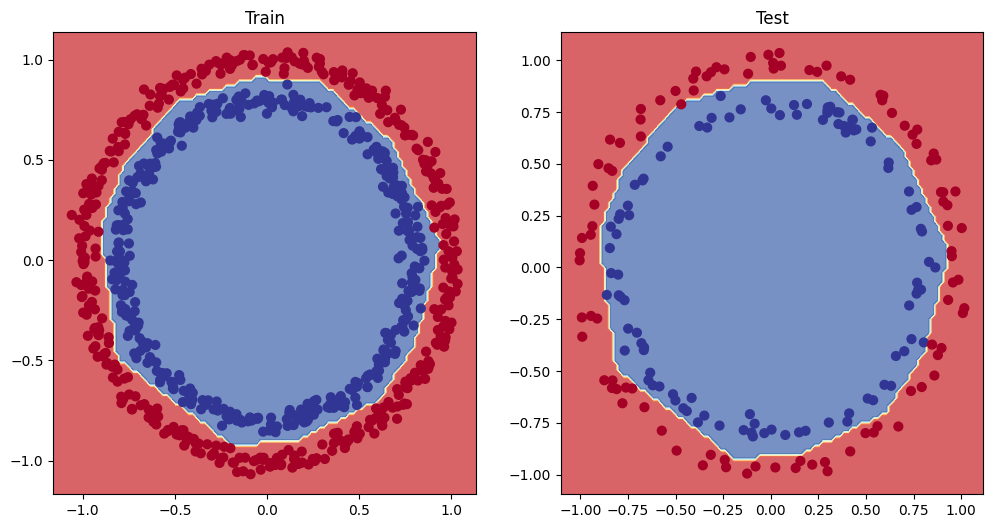

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

#5. Improving Our Model

Below are options we could use to improve our model:

*Add more layers - give the model more chances to learn about patterns in the data

*Add more hidden units

*fit for longer

*Changing the activation fucntions

*Change the learning rate

*Change the loss and optimiser functions

One way to troubleshoot to a larger problem is to test out a smaller problem.

#8. Putting it all together with aa multi-class classification problem



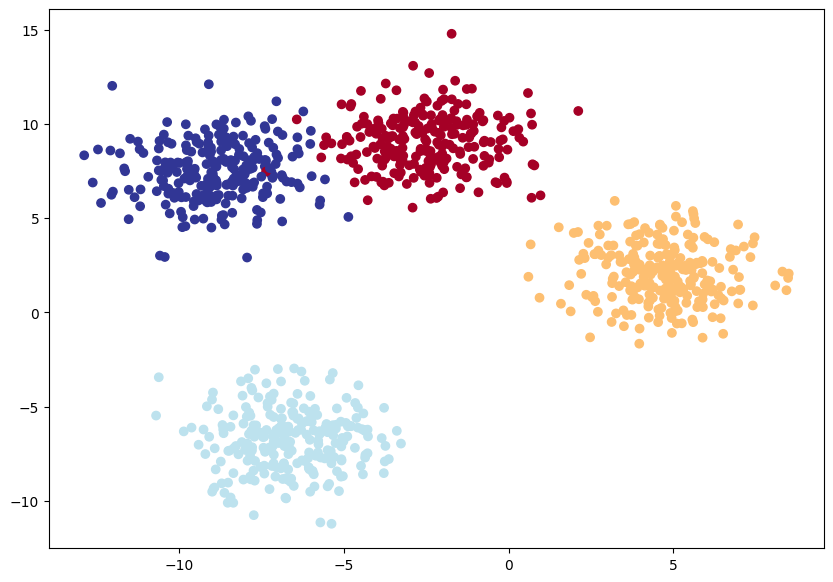

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#set the hyperparameters for data creation
num_classes = 4
num_features = 2
random_seed = 42

#1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                           n_features = num_features,
                           centers = num_classes,
                           cluster_std=1.5,
                           random_state = random_seed)

#2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

#3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = random_seed)

#4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(x=X_blob[:, 0],
            y=X_blob[:, 1],
            c=y_blob,
            cmap=plt.cm.RdYlBu)



#8.2 Building a multi-class classification model in PyTorch

You know an issue requrie non-linearity when straight lines alone wouldn't solve the problem.

Binary classes use Sigmoid/Softmax activtion and multiclass uses Binary Cross Entropy activation.

In [ ]:
#the class of the model
device = "cuda" if torch.cuda.is_available() else "cpu"

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    #initializes multi-class model
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2, output_features=4,
                    hidden_units = 8).to(device)

In [ ]:
#loss functions
loss_fn =  nn.CrossEntropyLoss()

#create an optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

#training the model and predicting the data
epochs = 800

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  #1. Forward pass
  y_logits = model_4(X_blob_train.to(device))
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  #2. Calculate the loss
  loss = loss_fn(y_logits, y_blob_train.type(torch.LongTensor).to(device))
  #acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backward
  loss.backward()

  #5.
  optimizer.step()

#testing
model_4.eval()
with torch.inference_mode():
  test_logits = model_4(X_blob_test)
  test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

  loss = loss_fn(test_logits, y_blob_test.type(torch.LongTensor).to(device))
  acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

  print(f"Loss: {loss:.5f}. Acc: {acc:.5f}")

Loss: 0.00951. Acc: 99.50000


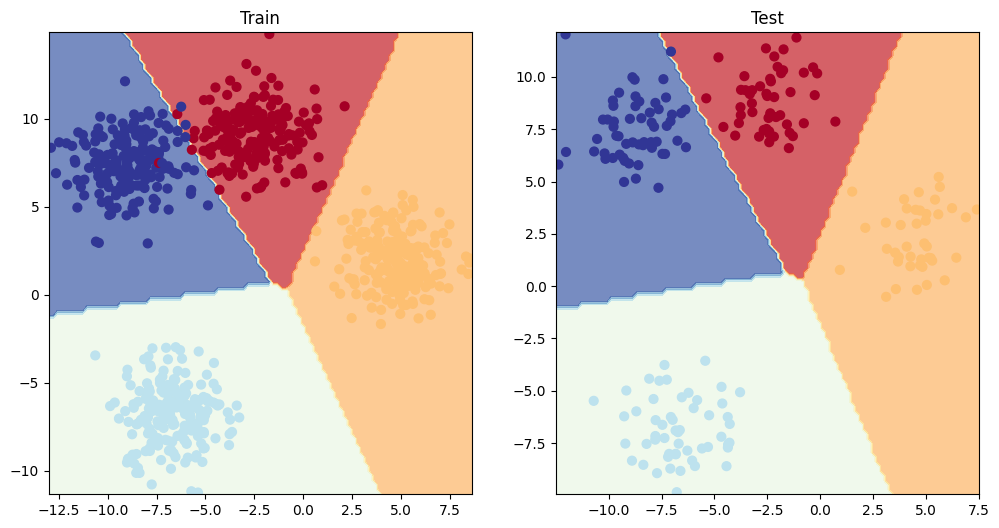

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


#Classification metrices...

*Accuracy - out of 100 samples , how many does out model get right? Not great for inbalanced classes. torchmetrics.Accuracy()

*Precision - higher precision leads to less false positivies. torchmetrices.Precision()

*Recall - higher recall leads to less false negatives. torchmetrics.Recall()

There is a precision recall tradeoff where increasing one often leads to the decreasing of another.

*F1-score

*Confusion matrix

*Classification report